In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This command unzips your file into a folder named '/content/dataset'
# The '!' runs it as a command-line command
# The '-q' flag means 'quiet' (it won't print the name of every file)

print("Starting to unzip... This may take a few minutes.")
!unzip -q "/content/drive/MyDrive/1_3.zip" -d "/content/dataset"
print("Unzipping complete!")

Starting to unzip... This may take a few minutes.
Unzipping complete!


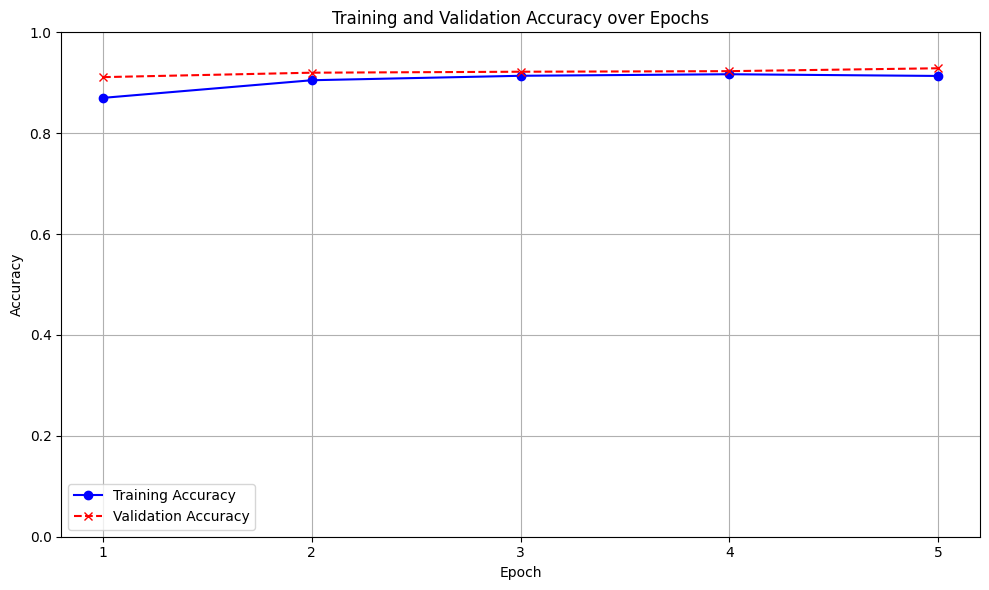

Training and Validation accuracy plot displayed.


In [5]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, marker='o', linestyle='-', color='blue', label='Training Accuracy')
plt.plot(epochs, val_accuracies, marker='x', linestyle='--', color='red', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.grid(True)
plt.xticks(epochs)
plt.ylim(0, 1) # Accuracy ranges from 0 to 1
plt.legend()
plt.tight_layout()
plt.show()

print("Training and Validation accuracy plot displayed.")

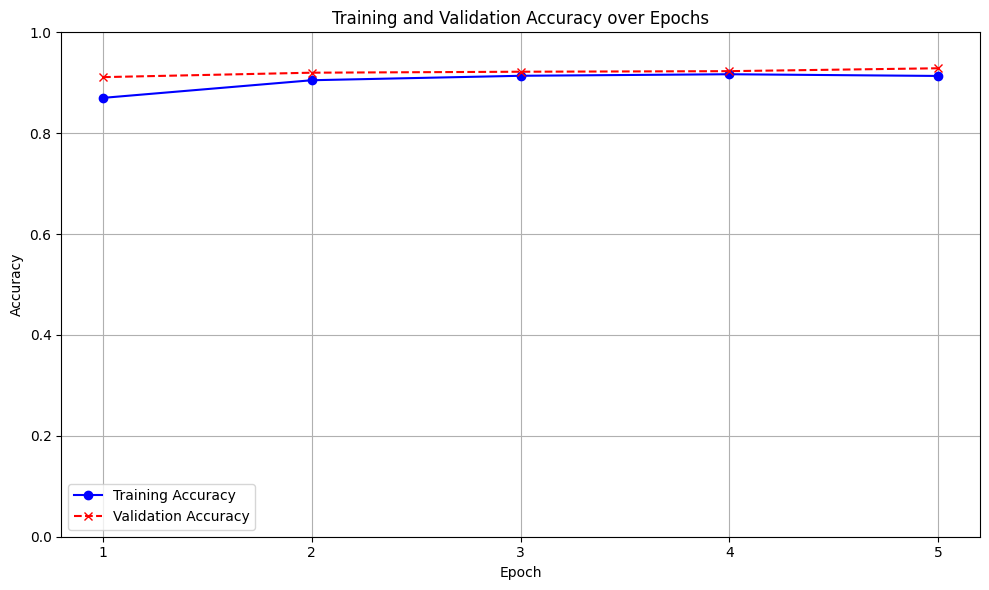

Training and Validation accuracy plot displayed.


In [7]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, marker='o', linestyle='-', color='blue', label='Training Accuracy')
plt.plot(epochs, val_accuracies, marker='x', linestyle='--', color='red', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.grid(True)
plt.xticks(epochs)
plt.ylim(0, 1) # Accuracy ranges from 0 to 1
plt.legend()
plt.tight_layout()
plt.show()

print("Training and Validation accuracy plot displayed.")

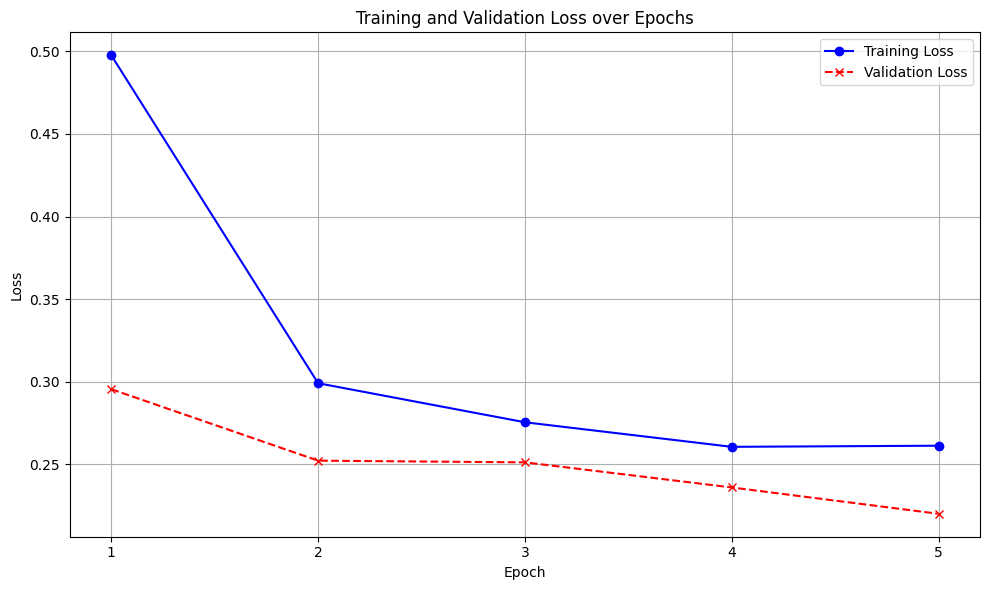

Training and Validation loss plot displayed.


In [8]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(epochs, val_losses, marker='x', linestyle='--', color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.grid(True)
plt.xticks(epochs)
plt.legend()
plt.tight_layout()
plt.show()

print("Training and Validation loss plot displayed.")

In [ ]:
!ls -F /content/dataset/

raw-img/  translate.py


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# --- 1. Setup and Parameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model parameters
# NUM_CLASSES will be inferred from the dataset
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_EPOCHS = 5 # Start with a few epochs to test

# Data paths
data_dir = '/content/dataset/raw-img' # This directory contains the class folders directly

# --- 2. Define Data Transformations ---
# Data augmentation for training, simple resize/normalize for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- 3. Create DataLoaders ---
# Load the full dataset first, then split into train and val
full_dataset = torchvision.datasets.ImageFolder(data_dir, data_transforms['train'])

# Infer NUM_CLASSES from the dataset
NUM_CLASSES = len(full_dataset.classes)

# Define split ratios
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
image_datasets = {
    'train': train_dataset,
    'val': val_dataset
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes

print(f"Found {len(class_names)} classes: {class_names}")
print(f"Training set size: {dataset_sizes['train']} images")
print(f"Validation set size: {dataset_sizes['val']} images")


# --- 4. Load Pre-trained ResNet-50 ---
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all layers in the body
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the final layer
num_ftrs = model.fc.in_features

# Replace the final layer for our problem
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Move the model to the GPU
model = model.to(device)

# --- 5. Define Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()

# Only optimize the parameters of the final layer (since we froze the others)
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)


# --- 6. Training Loop with Validation and Metric Collection ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_train_loss = running_loss / dataset_sizes['train']
    epoch_train_acc = running_corrects.double() / dataset_sizes['train']

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc.item())

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

    epoch_val_loss = val_running_loss / dataset_sizes['val']
    epoch_val_acc = val_running_corrects.double() / dataset_sizes['val']

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc.item())

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

print("Training finished.")


Using device: cuda
Found 10 classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Training set size: 20943 images
Validation set size: 5236 images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Starting training...
Epoch 1/5 | Train Loss: 0.4977 Acc: 0.8701 | Val Loss: 0.2954 Acc: 0.9112
Epoch 2/5 | Train Loss: 0.2990 Acc: 0.9050 | Val Loss: 0.2521 Acc: 0.9200
Epoch 3/5 | Train Loss: 0.2754 Acc: 0.9139 | Val Loss: 0.2511 Acc: 0.9219
Epoch 4/5 | Train Loss: 0.2605 Acc: 0.9169 | Val Loss: 0.2359 Acc: 0.9230
Epoch 5/5 | Train Loss: 0.2612 Acc: 0.9135 | Val Loss: 0.2199 Acc: 0.9288
Training finished.


In [ ]:
!ls -F /content/dataset/raw-img/

cane/	  elefante/  gallina/  mucca/	ragno/
cavallo/  farfalla/  gatto/    pecora/	scoiattolo/


In [ ]:
model.eval() # Set model to evaluation mode
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().tolist())
        all_predictions.extend(predicted.cpu().tolist())

print("Collected true and predicted labels for evaluation.")

Collected true and predicted labels for evaluation.


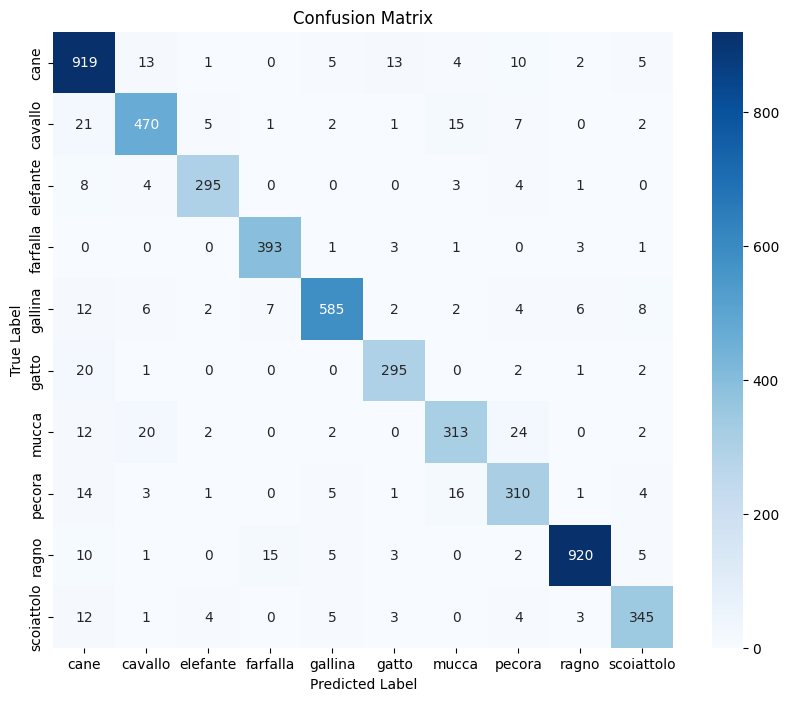

Confusion matrix plotted.


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print("Confusion matrix plotted.")

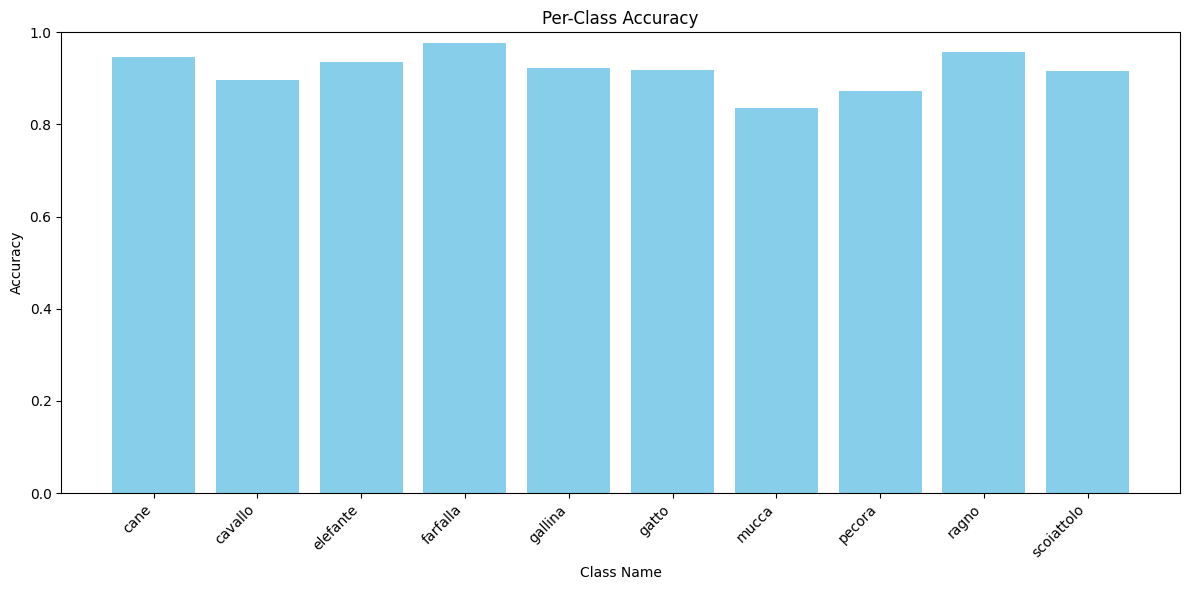

Accuracy for class 'cane': 0.95
Accuracy for class 'cavallo': 0.90
Accuracy for class 'elefante': 0.94
Accuracy for class 'farfalla': 0.98
Accuracy for class 'gallina': 0.92
Accuracy for class 'gatto': 0.92
Accuracy for class 'mucca': 0.83
Accuracy for class 'pecora': 0.87
Accuracy for class 'ragno': 0.96
Accuracy for class 'scoiattolo': 0.92
Per-class accuracy plotted and displayed.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Calculate true positives (diagonal of confusion matrix)
true_positives = np.diag(cm)

# 2. Calculate total samples for each class (sum of each row in confusion matrix)
total_samples_per_class = np.sum(cm, axis=1)

# 3. Compute per-class accuracy
# Handle potential division by zero for classes with no samples
per_class_accuracy = np.where(total_samples_per_class > 0, true_positives / total_samples_per_class, 0)

# 4. Create a bar plot of per-class accuracies
plt.figure(figsize=(12, 6))
plt.bar(class_names, per_class_accuracy, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1) # Accuracy ranges from 0 to 1
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

for i, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {per_class_accuracy[i]:.2f}")

print("Per-class accuracy plotted and displayed.")

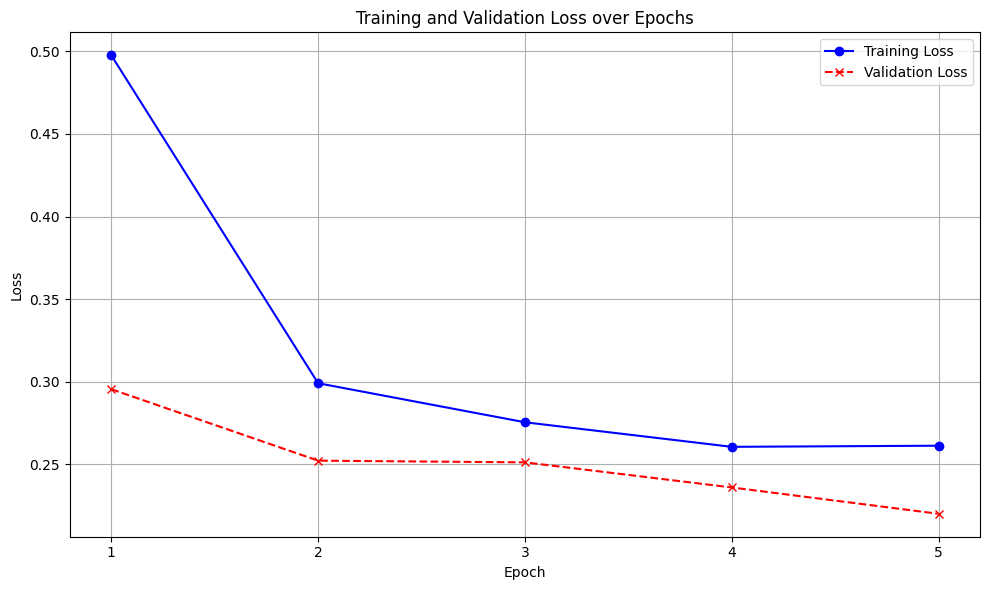

Training and Validation loss plot displayed.


In [4]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(epochs, val_losses, marker='x', linestyle='--', color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.grid(True)
plt.xticks(epochs)
plt.legend()
plt.tight_layout()
plt.show()

print("Training and Validation loss plot displayed.")

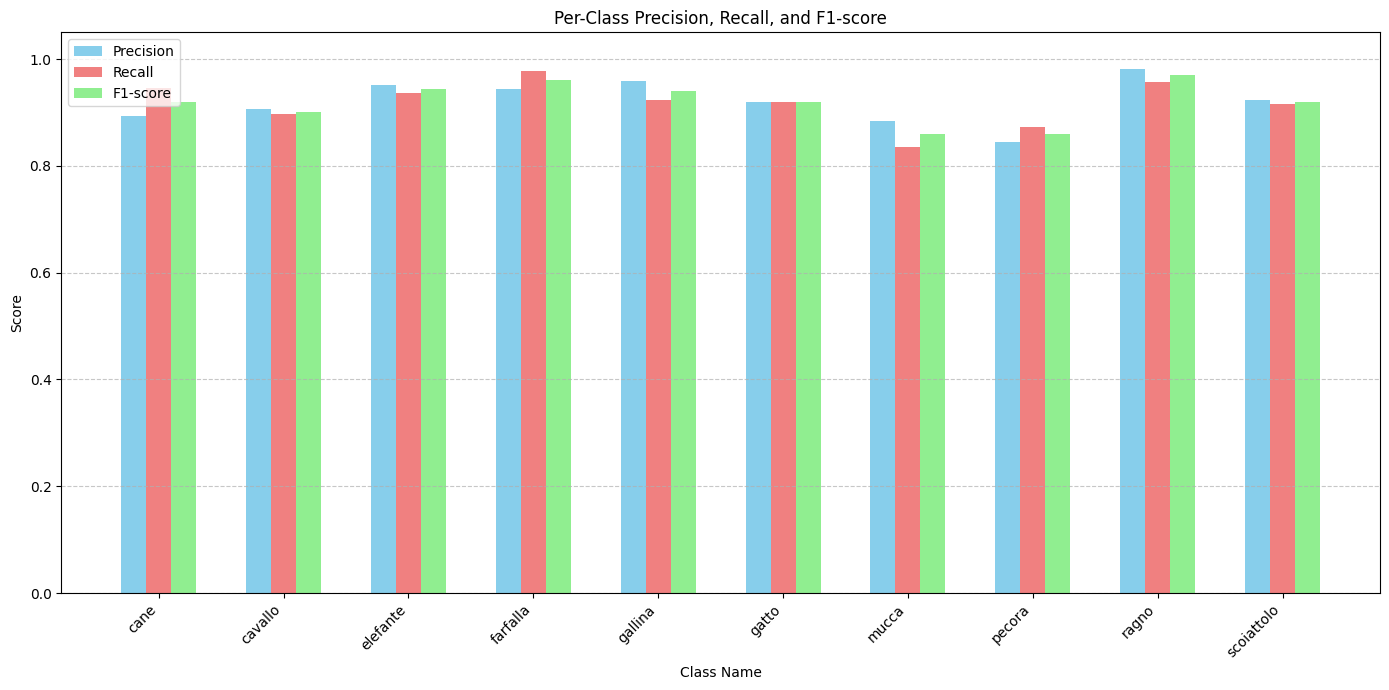

Per-class Precision, Recall, and F1-score calculated and plotted.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store metrics
precisions = []
recalls = []
f1_scores = []

# Iterate through each class to calculate metrics
for i in range(len(class_names)):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP

    # Calculate Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Calculate Recall
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1-score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Plotting the grouped bar chart

bar_width = 0.2
index = np.arange(len(class_names))

plt.figure(figsize=(14, 7))
bar1 = plt.bar(index, precisions, bar_width, label='Precision', color='skyblue')
bar2 = plt.bar(index + bar_width, recalls, bar_width, label='Recall', color='lightcoral')
bar3 = plt.bar(index + 2 * bar_width, f1_scores, bar_width, label='F1-score', color='lightgreen')

plt.xlabel('Class Name')
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall, and F1-score')
plt.xticks(index + bar_width, class_names, rotation=45, ha='right')
plt.ylim(0, 1.05) # Scores range from 0 to 1
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Per-class Precision, Recall, and F1-score calculated and plotted.")

# Optional: Print the metrics for inspection
# for i, class_name in enumerate(class_names):
#     print(f"Class '{class_name}': Precision={precisions[i]:.2f}, Recall={recalls[i]:.2f}, F1-score={f1_scores[i]:.2f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

misclassified_samples = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    # Enumerate through the validation dataloader to get batch index and data
    for batch_idx, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Find misclassified images in the current batch
        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

        # Store information for misclassified images
        for i in incorrect_indices:
            # Calculate the global index of the misclassified image in the full validation dataset

            # First, get the index within the current batch
            idx_in_batch = i.item()

            # Then, get the global index within the Subset
            global_idx_in_subset = batch_idx * BATCH_SIZE + idx_in_batch

            # Ensure the global_idx_in_subset is within the bounds of the val_dataset
            if global_idx_in_subset < len(val_dataset):
                # The actual index in the original full_dataset is stored in val_dataset.indices
                original_dataset_idx = val_dataset.indices[global_idx_in_subset]

                misclassified_samples.append({
                    'original_dataset_idx': original_dataset_idx,
                    'true_label': labels[i].item(),
                    'predicted_label': predicted[i].item()
                })

print(f"Found {len(misclassified_samples)} misclassified samples.")

Found 370 misclassified samples.


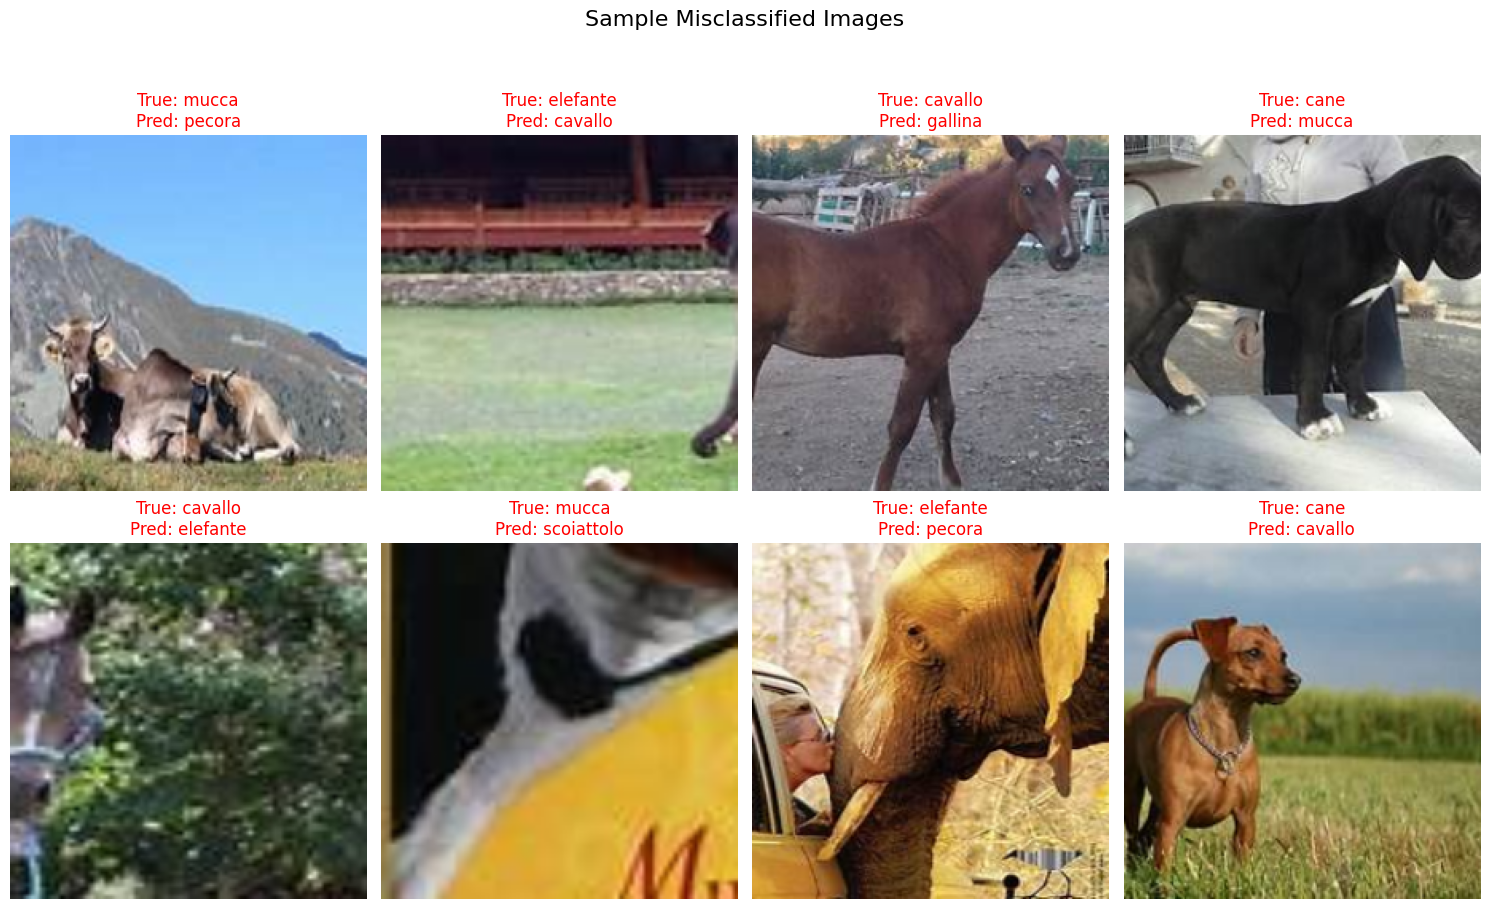

Displayed 8 misclassified images.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Denormalization function (reverse the normalization applied during data transformation)
# Normalization: image = (image - mean) / std
# Denormalization: image = image * std + mean
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Identify indices of challenging classes based on previous analysis ('mucca', 'pecora', 'cavallo')
challenging_class_names = ['mucca', 'pecora', 'cavallo']
challenging_class_indices = [class_names.index(c) for c in challenging_class_names if c in class_names]

# Filter misclassified samples, prioritizing challenging classes
misclassified_challenging_samples = []
misclassified_other_samples = []

for sample in misclassified_samples:
    if sample['true_label'] in challenging_class_indices or sample['predicted_label'] in challenging_class_indices:
        misclassified_challenging_samples.append(sample)
    else:
        misclassified_other_samples.append(sample)

# Combine and select a subset for display, prioritizing challenging ones
display_samples = misclassified_challenging_samples + misclassified_other_samples
num_display_samples = min(8, len(display_samples)) # Display up to 8 samples

plt.figure(figsize=(15, 10))

for i in range(num_display_samples):
    sample_info = display_samples[i]
    original_idx = sample_info['original_dataset_idx']
    true_label = sample_info['true_label']
    predicted_label = sample_info['predicted_label']

    # Retrieve the image from the full_dataset (which has the original transforms)
    image, _ = full_dataset[original_idx]

    # Denormalize the image tensor for display
    img_to_display = denormalize(image.clone())

    # Convert to numpy array and rearrange dimensions for matplotlib (C, H, W -> H, W, C)
    img_np = img_to_display.numpy().transpose((1, 2, 0))

    ax = plt.subplot(2, 4, i + 1)
    ax.imshow(img_np)
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}", color='red')
    ax.axis('off')

plt.suptitle('Sample Misclassified Images', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()

print(f"Displayed {num_display_samples} misclassified images.")